In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#  Environment class — TankLevel
class TankLevel:
    def __init__(self, set_point, initial_state, initial_action):
        self.Sp = set_point
        self.S0 = initial_state
        self.A0 = initial_action
        self.state_table = list(np.round(np.linspace(-1.2, 1.2, 25), 2))
        self.action_table = list(np.round(np.linspace(-0.014, 0.014, 29), 3))

    def RL_state(self, s):
        state = np.round(s - self.Sp, 1)
        S = self.state_table.index(state)
        return S

    def step(self, a):
        self.A0 = self.get_action(a)
        self.S0 = self.next_state(self.A0)
        reward = self.reward_calc(self.S0)
        next_s = self.convert_state(self.S0)
        done = self.state_table[next_s] == 0
        return next_s, reward, done

    def test_step(self, a):
        self.A0 = self.get_action(a)
        Ts = 0.1
        for i in range(10):
            self.S0 = self.S0 + (Ts / 0.79) * (self.A0 - 0.0133 * np.sqrt(self.S0))
            self.S0 = np.round(self.S0, 6)
        next_s = self.convert_state(self.S0)
        reward = self.reward_calc(self.S0)
        done = self.state_table[next_s] == 0
        return next_s, reward, done

    def diff(self, S0, A):
        Ts = 0.1
        for i in range(10):
            S0 = self.S0 + (Ts / 0.79) * (A - 0.0133 * np.sqrt(S0))
        s = self.convert_state(S0)
        return s

    def get_action(self, a):
        A = max(0, self.A0 + self.action_table[a])
        A = min(0.014, A)
        return A

    def next_state(self, A):
        S = np.divide(np.square(A), np.square(0.0133))
        return S

    def reward_calc(self, S):
        S = np.round(S - self.Sp, 1)
        reward = 100 if S == 0 else -np.square(S)*100
        return reward

    def convert_state(self, S):
        state = np.round(S - self.Sp, 1)
        s = self.state_table.index(state)
        return s

In [2]:
# Service functions
def init_Q(s, a, type="zeros"):
    if type == "ones":
        return np.ones((s, a))
    elif type == "random":
        return np.random.random((s, a))
    else:
        return np.zeros((s, a))

def e_greedy(no_a, e, q):
    return np.random.randint(0, no_a) if np.random.rand() < e else np.argmax(q)

# TD-Q learning function
def TD_Q(alpha, gamma, epsilon, episodes, max_step):
    S = 1.0
    sp = 0.5
    A = 0.0133
    env = TankLevel(sp, S, A)

    n_s, n_a = 25, 29
    Q = init_Q(n_s, n_a, "zeros")

    episode_reward = []
    state = []
    set_point = []

    for i in tqdm(range(episodes)):
        t = 0
        total_reward = 0

        if i > 0 and i % 1000 == 0:
            sp_range = list(np.round(np.linspace(0, 1.2, 13), 1))
            env.Sp = float(np.random.choice(sp_range, 1))

        if i > 0 and i % 500 == 0:
            epsilon = max(0.1, epsilon - 0.01)

        s = env.RL_state(S)
        a = e_greedy(n_a, epsilon, Q[s, :])

        while t < max_step:
            next_s, reward, done = env.step(a)
            next_a = e_greedy(n_a, epsilon, Q[next_s, :])
            max_a = np.argmax(Q[next_s, :])
            total_reward += reward

            if done:
                Q[s, a] += alpha * (reward - Q[s, a])
            else:
                Q[s, a] += alpha * (reward + gamma * Q[next_s, max_a] - Q[s, a])

            state.append(env.S0)
            set_point.append(env.Sp)
            t += 1
            s, a = next_s, next_a

            if done:
                break

        episode_reward.append(total_reward)

    np.savetxt('Q_Mattrix', Q)
    return episode_reward, Q, state, set_point

In [7]:
# Testing function
def test(S, A, epsilon=0, n_test=15, max_steps=500):
    sp = 0.9
    n_a = 29
    Q = np.loadtxt('Q_Mattrix')
    env = TankLevel(sp, S, A)

    episode_reward = []
    set_point = []
    state = []
    action = []

    for i in tqdm(range(n_test)):
        t = 0
        total_reward = 0

        if i > 0 and i % 1 == 0:
            sp_range = list(np.round(np.linspace(0, 1.1, 13), 1))
            env.Sp = float(np.random.choice(sp_range, 1))

        s = env.RL_state(S)

        while t < max_steps:
            if t % 2 == 0:
                a = e_greedy(n_a, epsilon, Q[s, :])

            next_s, reward, done = env.test_step(a)

            s = next_s
            total_reward += reward
            t += 1

            set_point.append(env.Sp)
            state.append(env.S0)
            action.append(env.A0)

            if done:
                break

        episode_reward.append(total_reward)

    return episode_reward, state, set_point, action

In [8]:
# Model training
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 1000
max_steps = 500

train_rewards, Q, S_train, Sp_train = TD_Q(alpha, gamma, epsilon, episodes, max_steps)

100%|██████████| 1000/1000 [00:00<00:00, 10652.07it/s]


  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-7-f740a4273e25>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  env.Sp = float(np.random.choice(sp_range, 1))
100%|██████████| 15/15 [00:00<00:00, 19.42it/s]


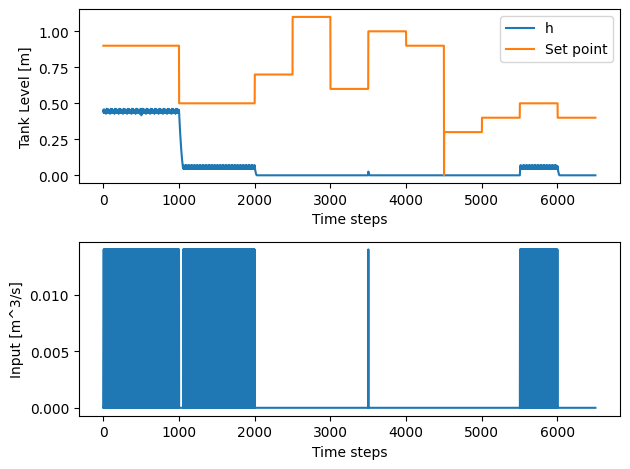

In [9]:
# Model testing
test_rewards, S, Sp, a = test(0.46, 0.0088, epsilon=0, n_test=15, max_steps=500)

plt.subplot(2, 1, 1)
plt.plot(S)
plt.plot(Sp)
plt.legend(['h', 'Set point'])
plt.xlabel('Time steps')
plt.ylabel('Tank Level [m]')

plt.subplot(2, 1, 2)
plt.plot(a)
plt.xlabel('Time steps')
plt.ylabel('Input [m^3/s]')
plt.tight_layout()
plt.show()

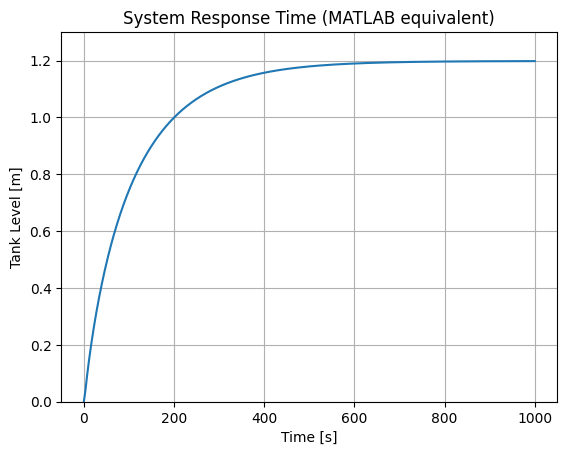

In [10]:
# Equivalent of system response with MATLAB
h = [0]
F = 0.010
Ts = 0.1
for i in range(10000):
    if i > 30:
        F = 0.01456
    h.append(h[-1] + ((Ts / 0.79) * (F - 0.0133 * np.sqrt(h[-1]))))

plt.plot(np.arange(0, Ts * len(h), Ts), h)
plt.ylim([0, 1.3])
plt.title('System Response Time (MATLAB equivalent)')
plt.xlabel('Time [s]')
plt.ylabel('Tank Level [m]')
plt.grid(True)
plt.show()